# AG2: Swarm (Use Case example)

Use Case example
- https://docs.ag2.ai/docs/user-guide/advanced-concepts/swarm/use-case

## SETUP

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables (for API key)
load_dotenv()

# Set up OpenAI API key
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("Please set the OPENAI_API_KEY environment variable or add it to a .env file")

# Define the model to use
MODEL_GPT = "gpt-4o-mini"

## Swarm Use Case Example

In this walk-through of a customer service workflow, we will utilize three of the advanced features available in a Swarm orchestration:
- Updating an agent’s state
- Nested chats
- Conditional handoffs

### Visualizing a Swarm

In [2]:
from IPython.display import Image

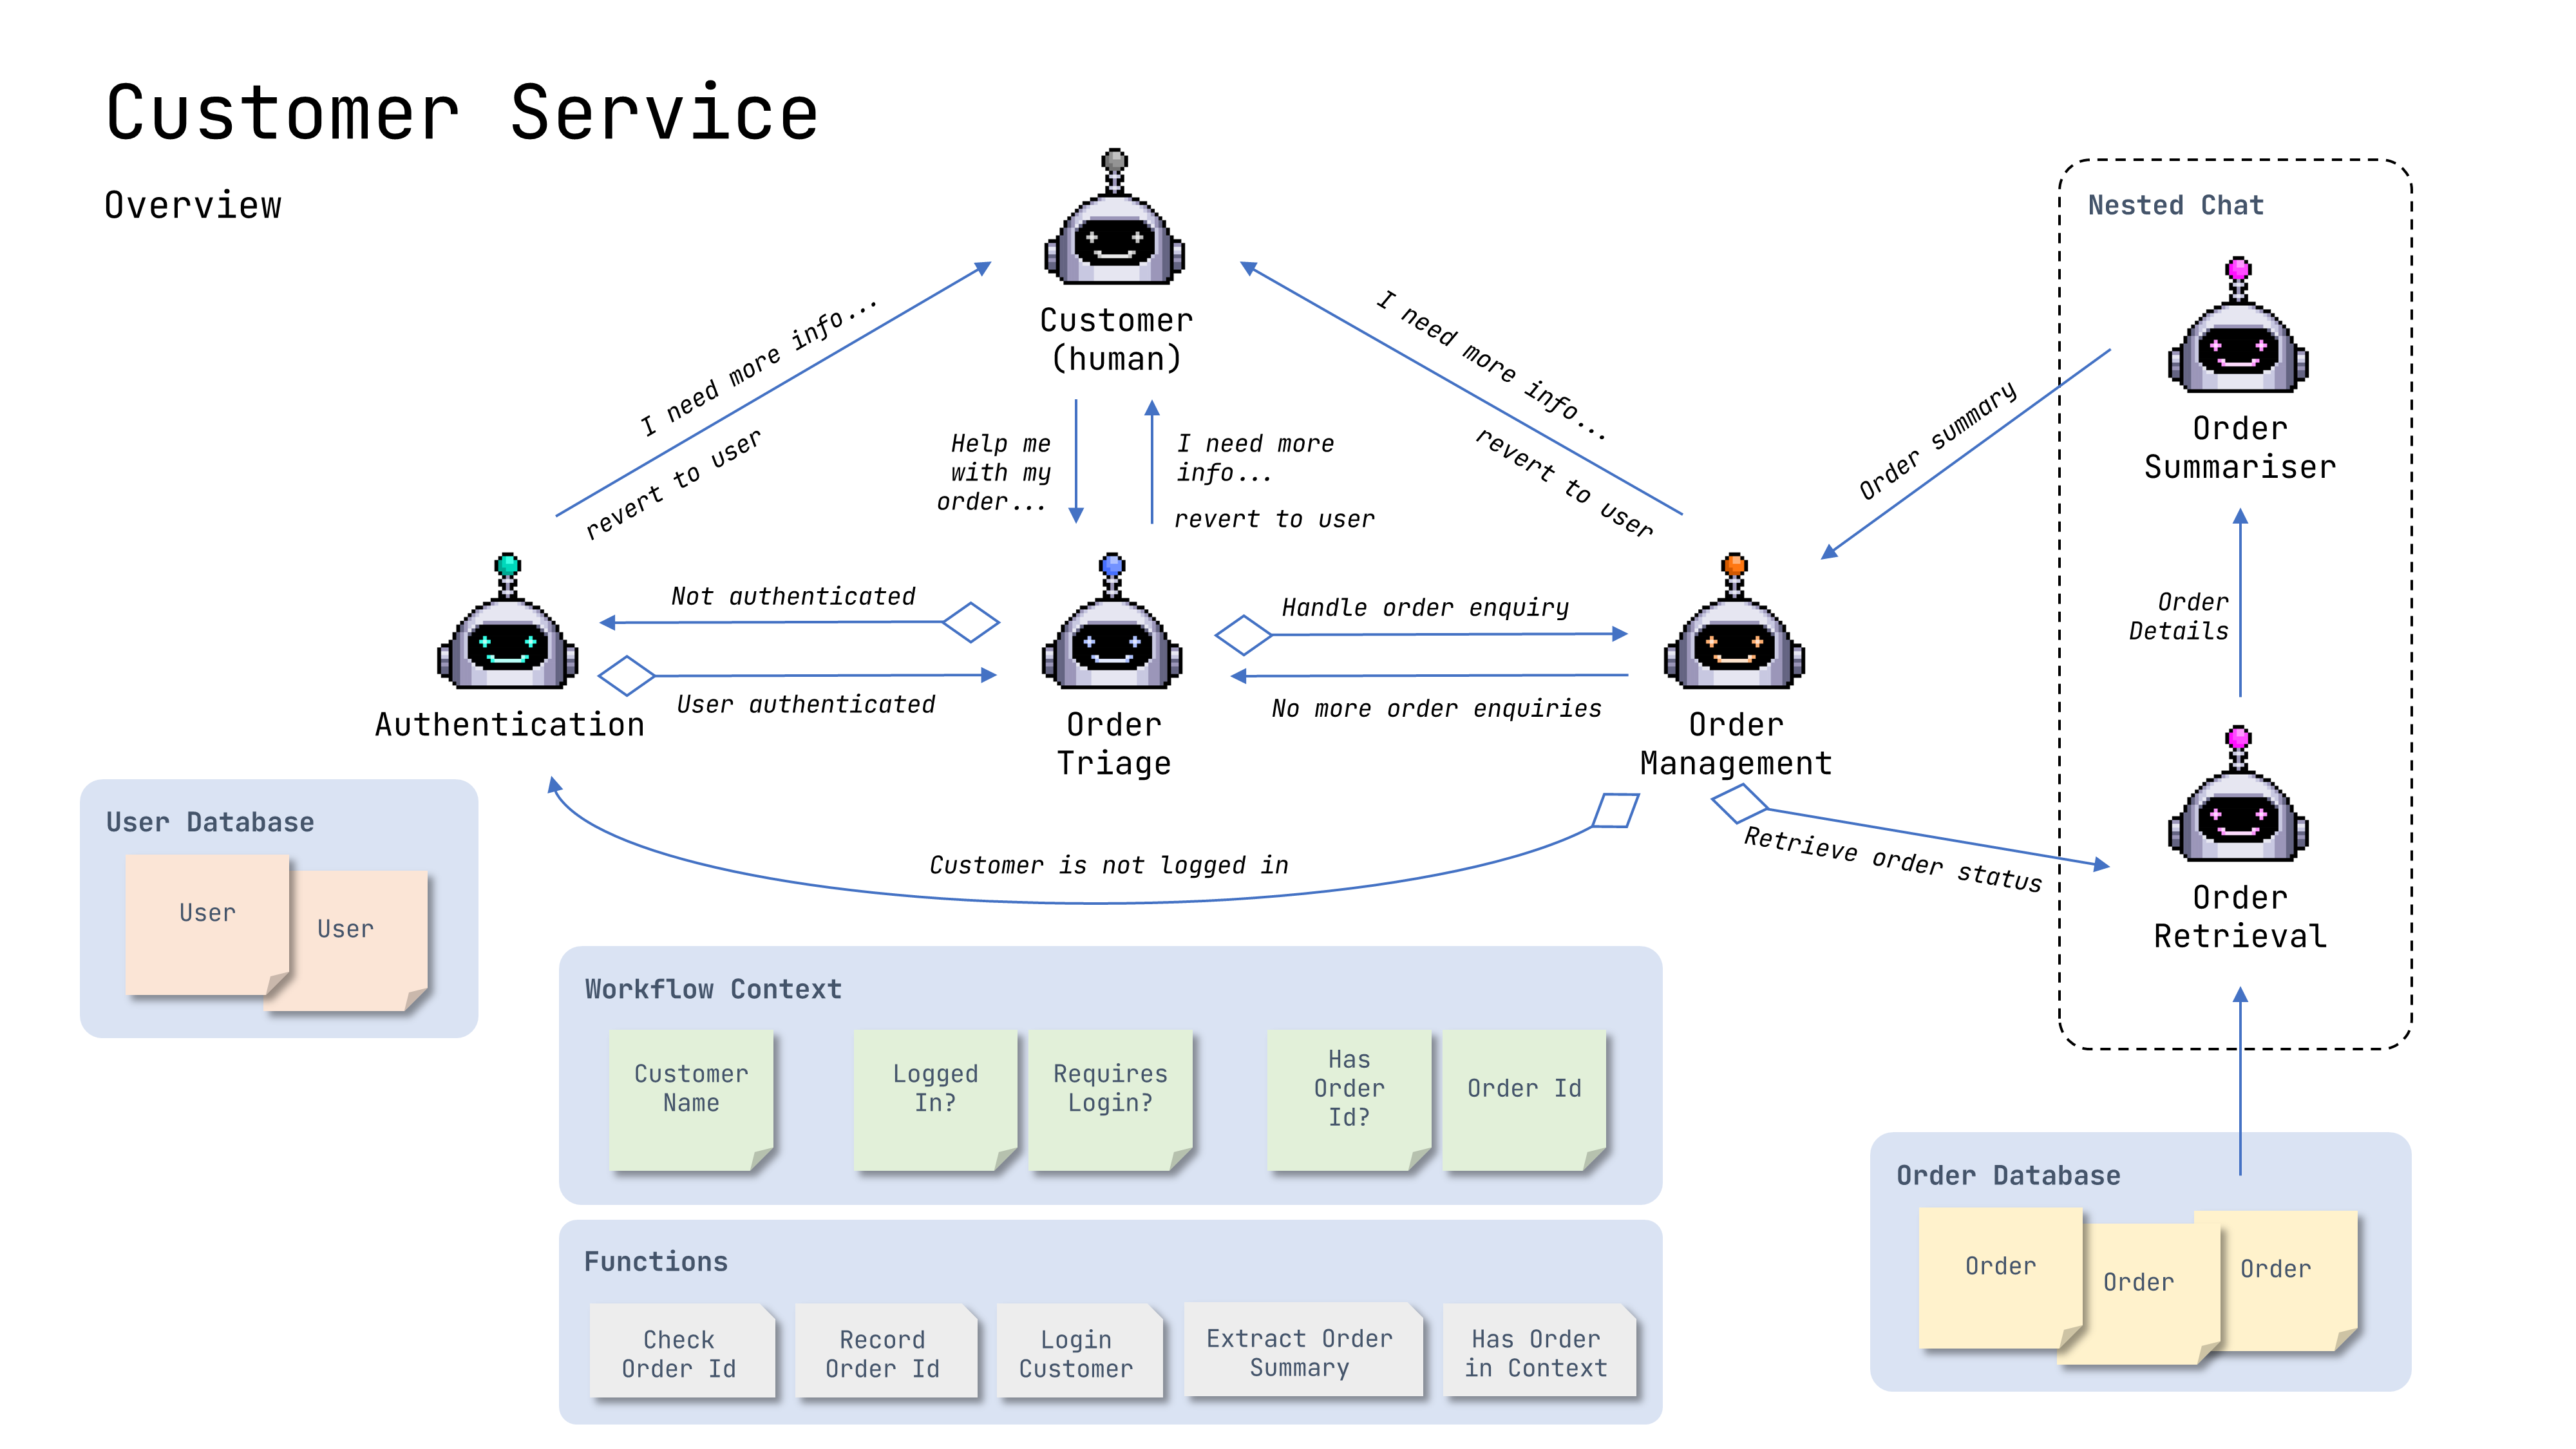

In [3]:
# It’s useful to draw your agents, flows, context variables, and tools
#   and then create the swarm based on the diagram.
# This is the scenario we will run through, with customers able to enquire about their orders.
#   However, we will make sure that they are authenticated to do so.

Image(filename='swarm-enhanced-01.png')

### Setting up

In [4]:
# Imports and an LLM configuration for all agents
from typing import Any, Dict, List

from autogen import (
    AfterWork,
    OnCondition,
    UpdateSystemMessage,
    AfterWorkOption,
    AssistantAgent,
    SwarmResult,
    UserProxyAgent,
    initiate_swarm_chat,
    register_hand_off,
    # LLMConfig,
)

# Put your key in the OPENAI_API_KEY environment variable
# llm_config = LLMConfig(api_type="openai", model="gpt-4o-mini")
llm_config = {"api_type": "openai", "model": "gpt-4o-mini", "api_key": os.environ["OPENAI_API_KEY"]}

### Context

In [5]:
workflow_context = {
    # customer details
    "customer_name": None,
    "logged_in_username": None,

    # workflow status
    "logged_in": False,
    "requires_login": True,

    # order enquiry details
    "has_order_id": False,
    "order_id": None,
}

### Mock database

In [6]:
# Mock Databases

USER_DATABASE = {
    "mark": {
        "full_name": "Mark Sze",
    },
    "kevin": {
        "full_name": "Yiran Wu",
    },
}

ORDER_DATABASE = {
    "TR13845": {
        "user": "mark",
        "order_number": "TR13845",
        "status": "shipped",  # order status: order_received, shipped, delivered, return_started, returned
        "return_status": "N/A",  # return status: N/A, return_started, return_shipped, return_delivered, refund_issued
        "product": "matress",
        "link": "https://www.example.com/TR13845",
        "shipping_address": "123 Main St, State College, PA 12345",
    },
    "TR14234": {
        "user": "kevin",
        "order_number": "TR14234",
        "status": "delivered",
        "return_status": "N/A",
        "product": "pillow",
        "link": "https://www.example.com/TR14234",
        "shipping_address": "123 Main St, State College, PA 12345",
    },
    "TR29384": {
        "user": "mark",
        "order_number": "TR29384",
        "status": "delivered",
        "return_status": "N/A",
        "product": "bed frame",
        "link": "https://www.example.com/TR29384",
        "shipping_address": "123 Main St, State College, PA 12345",
    },
}

### Order and Authentication Functions

In [7]:
# ORDER FUNCTIONS
def check_order_id(order_id: str, context_variables: dict) -> SwarmResult:
    """Check if the order ID is valid"""
    # Restricts order to checking to the logged in user
    if (
        context_variables["logged_in_username"]
        and order_id in ORDER_DATABASE
        and ORDER_DATABASE[order_id]["user"] == context_variables["logged_in_username"]
    ):
        return SwarmResult(
            context_variables=context_variables, values=f"Order ID {order_id} is valid.", agent=order_triage_agent
        )
    else:
        return SwarmResult(
            context_variables=context_variables,
            values=f"Order ID {order_id} is invalid. Please ask for the correct order ID.",
            agent=order_triage_agent,
        )

def record_order_id(order_id: str, context_variables: dict) -> SwarmResult:
    """Record the order ID in the workflow context"""
    if order_id not in ORDER_DATABASE:
        return SwarmResult(
            context_variables=context_variables,
            values=f"Order ID {order_id} not found. Please ask for the correct order ID.",
            agent=order_triage_agent,
        )

    context_variables["order_id"] = order_id
    context_variables["has_order_id"] = True
    return SwarmResult(
        context_variables=context_variables, values=f"Order ID Recorded: {order_id}", agent=order_mgmt_agent
    )

# AUTHENTICATION FUNCTIONS
def login_customer_by_username(username: str, context_variables: dict) -> SwarmResult:
    """Get and log the customer in by their username"""
    if username in USER_DATABASE:
        context_variables["customer_name"] = USER_DATABASE[username]["full_name"]
        context_variables["logged_in_username"] = username
        context_variables["logged_in"] = True
        context_variables["requires_login"] = False
        return SwarmResult(
            context_variables=context_variables,
            values=f"Welcome back our customer, {context_variables['customer_name']}! Please continue helping them.",
            agent=order_triage_agent,
        )
    else:
        return SwarmResult(
            context_variables=context_variables,
            values=f"User {username} not found. Please ask for the correct username.",
            agent=authentication_agent,
        )

### Agents with dynamic system message

In [8]:
# AGENTS

# Human customer
user = UserProxyAgent(
    name="customer",
    code_execution_config=False,
)

order_triage_prompt = """You are an order triage agent, working with a customer and a group of agents to provide support for your e-commerce platform.

An agent needs to be logged in to be able to access their order. The authentication_agent will work with the customer to verify their identity, transfer to them to start with.
The order_mgmt_agent will manage all order related tasks, such as tracking orders, managing orders, etc. Be sure to check the order as one step. Then if it's valid you can record it in the context.

Ask the customer for further information when necessary.

The current status of this workflow is:
Customer name: {customer_name}
Logged in: {logged_in}
Enquiring for Order ID: {order_id}
"""

order_triage_agent = AssistantAgent(
    name="order_triage_agent",
    update_agent_state_before_reply=[
        UpdateSystemMessage(order_triage_prompt),
    ],
    functions=[check_order_id, record_order_id],
    llm_config=llm_config,
)

authentication_prompt = "You are an authentication agent that verifies the identity of the customer."

authentication_agent = AssistantAgent(
    name="authentication_agent",
    system_message=authentication_prompt,
    functions=[login_customer_by_username],
    llm_config=llm_config,
)

order_management_prompt = """You are an order management agent that manages inquiries related to e-commerce orders.

The order must be logged in to access their order.

Use your available tools to get the status of the details from the customer. Ask the customer questions as needed.

The current status of this workflow is:
Customer name: {customer_name}
Logged in: {logged_in}
Enquiring for Order ID: {order_id}
"""

order_mgmt_agent = AssistantAgent(
    name="order_mgmt_agent",
    update_agent_state_before_reply=[
        UpdateSystemMessage(order_management_prompt),
    ],
    functions=[check_order_id, record_order_id],
    llm_config=llm_config,
)

### Nested chats

In [9]:
# NESTED CHAT - Delivery Status
order_retrieval_agent = AssistantAgent(
    name="order_retrieval_agent",
    system_message="You are an order retrieval agent that gets details about an order.",
    llm_config=llm_config,
)

order_summarizer_agent = AssistantAgent(
    name="order_summarizer_agent",
    system_message="You are an order summarizer agent that provides a summary of the order details.",
    llm_config=llm_config,
)

def extract_order_summary(recipient: AssistantAgent, messages, sender: AssistantAgent, config):
    """Extracts the order summary based on the OrderID in the context variables"""
    order_id = sender.get_context("order_id")
    if order_id in ORDER_DATABASE:
        order = ORDER_DATABASE[order_id]
        return f"Order {order['order_number']} for {order['product']} is currently {order['status']}. The shipping address is {order['shipping_address']}."
    else:
        return f"Order {order_id} not found."

nested_chat_one = {
    "carryover_config": {"summary_method": "last_msg"},
    "recipient": order_retrieval_agent,
    "message": extract_order_summary,  # "Retrieve the status details of the order using the order id",
    "max_turns": 1,
}

nested_chat_two = {
    "recipient": order_summarizer_agent,
    "message": "Summarize the order details provided in a tabulated, text-based, order sheet format",
    "max_turns": 1,
    "summary_method": "last_msg",
}

chat_queue = [nested_chat_one, nested_chat_two]

### Conditional hand-offs

In [10]:
# HANDOFFS
register_hand_off(
    agent=order_triage_agent,
    hand_to=[
        OnCondition(
            target=authentication_agent,
            condition="The customer is not logged in, authenticate the customer.",
            available="requires_login",
        ),
        OnCondition(
            target=order_mgmt_agent,
            condition="The customer is logged in, continue with the order triage.",
            available="logged_in",
        ),
        AfterWork(AfterWorkOption.REVERT_TO_USER),
    ]
)

register_hand_off(
    agent=authentication_agent,
    hand_to=[
        OnCondition(
            target=order_triage_agent,
            condition="The customer is logged in, continue with the order triage.",
            available="logged_in",
        ),
        AfterWork(AfterWorkOption.REVERT_TO_USER),
    ]
)

def has_order_in_context(agent: AssistantAgent, messages: List[Dict[str, Any]]) -> bool:
    return agent.get_context("has_order_id")

register_hand_off(
    agent=order_mgmt_agent,
    hand_to=[
        OnCondition(
            target={
                "chat_queue": chat_queue,
            },
            condition="Retrieve the status of the order",
            available=has_order_in_context,
        ),
        OnCondition(
            target=authentication_agent,
            condition="The customer is not logged in, authenticate the customer.",
            available="requires_login",
        ),
        OnCondition(target=order_triage_agent, condition="The customer has no more enquiries about this order."),
        AfterWork(AfterWorkOption.REVERT_TO_USER),
    ]
)

### Initiate Swarm and run

In [11]:
# chat_history = initiate_swarm_chat(
chat_result, context_variables, last_agent = initiate_swarm_chat(
    initial_agent=order_triage_agent,
    agents=[order_triage_agent, authentication_agent, order_mgmt_agent],
    context_variables=workflow_context,
    messages="Can you help me with my order.",
    user_agent=user,
    max_rounds=40,
    after_work=AfterWorkOption.TERMINATE,
)

customer (to chat_manager):



C:\Users\Pavel\projects\ai-llm-agents\.venv\Lib\site-packages\pydantic\main.py:1630: RuntimeWarning: fields may not start with an underscore, ignoring "_x"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)
C:\Users\Pavel\projects\ai-llm-agents\.venv\Lib\site-packages\autogen\agentchat\conversable_agent.py:2911: UserWarning: Function 'check_order_id' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)
C:\Users\Pavel\projects\ai-llm-agents\.venv\Lib\site-packages\autogen\agentchat\conversable_agent.py:2911: UserWarning: Function 'record_order_id' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)


Can you help me with my order.

--------------------------------------------------------------------------------

Next speaker: order_triage_agent

order_triage_agent (to chat_manager):

I can help you with that, but it appears that you are not logged in yet. Let's start by authenticating your identity. Can you please provide your login details?

--------------------------------------------------------------------------------

Next speaker: customer



Replying as customer. Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  



>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
customer (to chat_manager):



--------------------------------------------------------------------------------

Next speaker: order_triage_agent



C:\Users\Pavel\projects\ai-llm-agents\.venv\Lib\site-packages\autogen\agentchat\conversable_agent.py:3002: UserWarning: Function 'transfer_order_triage_agent_to_authentication_agent' is being overridden.
  warnings.warn(f"Function '{tool_sig['function']['name']}' is being overridden.", UserWarning)


order_triage_agent (to chat_manager):

***** Suggested tool call (call_lfBaT1cUoKQyhHSzCyLMCh4e): transfer_order_triage_agent_to_authentication_agent *****
Arguments: 
{}
********************************************************************************************************************

--------------------------------------------------------------------------------

Next speaker: _Swarm_Tool_Executor


>>>>>>>> EXECUTING FUNCTION transfer_order_triage_agent_to_authentication_agent...
Call ID: call_lfBaT1cUoKQyhHSzCyLMCh4e
Input arguments: {}
_Swarm_Tool_Executor (to chat_manager):

***** Response from calling tool (call_lfBaT1cUoKQyhHSzCyLMCh4e) *****
Swarm agent --> authentication_agent
**********************************************************************

--------------------------------------------------------------------------------

Next speaker: authentication_agent

authentication_agent (to chat_manager):

Please provide your username so I can assist you with logging in.

---

Replying as customer. Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  barry


customer (to chat_manager):

barry

--------------------------------------------------------------------------------

Next speaker: authentication_agent

authentication_agent (to chat_manager):

***** Suggested tool call (call_yxFIZZZl3emOMWBPRzSdOHJP): login_customer_by_username *****
Arguments: 
{"username":"barry"}
*******************************************************************************************

--------------------------------------------------------------------------------

Next speaker: _Swarm_Tool_Executor


>>>>>>>> EXECUTING FUNCTION login_customer_by_username...
Call ID: call_yxFIZZZl3emOMWBPRzSdOHJP
Input arguments: {'username': 'barry'}
_Swarm_Tool_Executor (to chat_manager):

***** Response from calling tool (call_yxFIZZZl3emOMWBPRzSdOHJP) *****
User barry not found. Please ask for the correct username.
**********************************************************************

--------------------------------------------------------------------------------

Next sp

Replying as customer. Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  mark


customer (to chat_manager):

mark

--------------------------------------------------------------------------------

Next speaker: authentication_agent

authentication_agent (to chat_manager):

***** Suggested tool call (call_umesOLnLPoNev2cJoKaN9mby): login_customer_by_username *****
Arguments: 
{"username":"mark"}
*******************************************************************************************

--------------------------------------------------------------------------------

Next speaker: _Swarm_Tool_Executor


>>>>>>>> EXECUTING FUNCTION login_customer_by_username...
Call ID: call_umesOLnLPoNev2cJoKaN9mby
Input arguments: {'username': 'mark'}
_Swarm_Tool_Executor (to chat_manager):

***** Response from calling tool (call_umesOLnLPoNev2cJoKaN9mby) *****
Welcome back our customer, Mark Sze! Please continue helping them.
**********************************************************************

--------------------------------------------------------------------------------

Ne

Replying as customer. Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  TR14234


customer (to chat_manager):

TR14234

--------------------------------------------------------------------------------

Next speaker: order_mgmt_agent



C:\Users\Pavel\projects\ai-llm-agents\.venv\Lib\site-packages\autogen\agentchat\conversable_agent.py:3002: UserWarning: Function 'transfer_order_mgmt_agent_to_order_triage_agent' is being overridden.
  warnings.warn(f"Function '{tool_sig['function']['name']}' is being overridden.", UserWarning)


order_mgmt_agent (to chat_manager):

***** Suggested tool call (call_tLqjSduc2ru0L7PeqyfxfC8z): record_order_id *****
Arguments: 
{"order_id":"TR14234"}
********************************************************************************

--------------------------------------------------------------------------------

Next speaker: _Swarm_Tool_Executor


>>>>>>>> EXECUTING FUNCTION record_order_id...
Call ID: call_tLqjSduc2ru0L7PeqyfxfC8z
Input arguments: {'order_id': 'TR14234'}
_Swarm_Tool_Executor (to chat_manager):

***** Response from calling tool (call_tLqjSduc2ru0L7PeqyfxfC8z) *****
Order ID Recorded: TR14234
**********************************************************************

--------------------------------------------------------------------------------

Next speaker: order_mgmt_agent

order_mgmt_agent (to chat_manager):

***** Suggested tool call (call_ESgxiquZdDPlPq7TycvtUjc6): check_order_id *****
Arguments: 
{"order_id":"TR14234"}
******************************************

C:\Users\Pavel\projects\ai-llm-agents\.venv\Lib\site-packages\autogen\agentchat\conversable_agent.py:3002: UserWarning: Function 'transfer_order_triage_agent_to_order_mgmt_agent' is being overridden.
  warnings.warn(f"Function '{tool_sig['function']['name']}' is being overridden.", UserWarning)


order_triage_agent (to chat_manager):

***** Suggested tool call (call_YNTeciSViasrvBZdhlTwffPh): transfer_order_triage_agent_to_authentication_agent *****
Arguments: 
{}
********************************************************************************************************************
***** Suggested tool call (call_L2WT5sVRQsNyRIz4xYebYVj0): transfer_order_triage_agent_to_order_mgmt_agent *****
Arguments: 
{}
****************************************************************************************************************

--------------------------------------------------------------------------------

Next speaker: _Swarm_Tool_Executor


>>>>>>>> EXECUTING FUNCTION transfer_order_triage_agent_to_authentication_agent...
Call ID: call_YNTeciSViasrvBZdhlTwffPh
Input arguments: {}

>>>>>>>> EXECUTING FUNCTION transfer_order_triage_agent_to_order_mgmt_agent...
Call ID: call_L2WT5sVRQsNyRIz4xYebYVj0
Input arguments: {}
_Swarm_Tool_Executor (to chat_manager):

***** Response from calling t

C:\Users\Pavel\projects\ai-llm-agents\.venv\Lib\site-packages\autogen\agentchat\conversable_agent.py:3002: UserWarning: Function 'transfer_order_mgmt_agent_to_nested_chat_order_mgmt_agent_1' is being overridden.
  warnings.warn(f"Function '{tool_sig['function']['name']}' is being overridden.", UserWarning)


order_mgmt_agent (to chat_manager):

It seems that the Order ID "TR14234" is invalid. Could you please double-check and provide the correct Order ID?

--------------------------------------------------------------------------------

Next speaker: customer



Replying as customer. Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  TR13845


customer (to chat_manager):

TR13845

--------------------------------------------------------------------------------

Next speaker: order_mgmt_agent

order_mgmt_agent (to chat_manager):

***** Suggested tool call (call_Zo2nW1NVJLs6gcVe7Vlsnzft): record_order_id *****
Arguments: 
{"order_id": "TR13845"}
********************************************************************************
***** Suggested tool call (call_8TsnatzBywNzj6EXG3U0CiAQ): check_order_id *****
Arguments: 
{"order_id": "TR13845"}
*******************************************************************************

--------------------------------------------------------------------------------

Next speaker: _Swarm_Tool_Executor


>>>>>>>> EXECUTING FUNCTION record_order_id...
Call ID: call_Zo2nW1NVJLs6gcVe7Vlsnzft
Input arguments: {'order_id': 'TR13845'}

>>>>>>>> EXECUTING FUNCTION check_order_id...
Call ID: call_8TsnatzBywNzj6EXG3U0CiAQ
Input arguments: {'order_id': 'TR13845'}
_Swarm_Tool_Executor (to chat_manager):

**

Replying as customer. Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  All good


customer (to chat_manager):

All good

--------------------------------------------------------------------------------

Next speaker: order_mgmt_agent

order_mgmt_agent (to chat_manager):

***** Suggested tool call (call_EPFhouLnlhmoRazG7auObbPe): transfer_order_mgmt_agent_to_order_triage_agent *****
Arguments: 
{}
****************************************************************************************************************

--------------------------------------------------------------------------------

Next speaker: _Swarm_Tool_Executor


>>>>>>>> EXECUTING FUNCTION transfer_order_mgmt_agent_to_order_triage_agent...
Call ID: call_EPFhouLnlhmoRazG7auObbPe
Input arguments: {}
_Swarm_Tool_Executor (to chat_manager):

***** Response from calling tool (call_EPFhouLnlhmoRazG7auObbPe) *****
Swarm agent --> order_triage_agent
**********************************************************************

--------------------------------------------------------------------------------

Next speak

Replying as customer. Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  exit


### PRINT

In [12]:
print(type(chat_result))
print(type(context_variables))
print(type(last_agent))

<class 'autogen.agentchat.chat.ChatResult'>
<class 'dict'>
<class 'autogen.agentchat.assistant_agent.AssistantAgent'>


In [13]:
print(len(chat_result.chat_history))
print(chat_result.summary)
print(chat_result.chat_history)

39
I'm glad to hear that everything is good! If you have any more questions in the future or need assistance, feel free to reach out. Have a great day!
[{'content': 'Can you help me with my order.', 'role': 'assistant', 'name': 'customer'}, {'content': "I can help you with that, but it appears that you are not logged in yet. Let's start by authenticating your identity. Can you please provide your login details?", 'name': 'order_triage_agent', 'role': 'user'}, {'content': '', 'role': 'assistant', 'name': 'customer'}, {'content': 'None', 'tool_calls': [{'id': 'call_lfBaT1cUoKQyhHSzCyLMCh4e', 'function': {'arguments': '{}', 'name': 'transfer_order_triage_agent_to_authentication_agent'}, 'type': 'function'}], 'name': 'order_triage_agent', 'role': 'assistant'}, {'content': 'Swarm agent --> authentication_agent', 'tool_responses': [{'tool_call_id': 'call_lfBaT1cUoKQyhHSzCyLMCh4e', 'role': 'tool', 'content': 'Swarm agent --> authentication_agent'}], 'name': '_Swarm_Tool_Executor', 'role': 'to

In [14]:
print(context_variables)

{'customer_name': 'Mark Sze', 'logged_in_username': 'mark', 'logged_in': True, 'requires_login': False, 'has_order_id': True, 'order_id': 'TR13845'}


In [15]:
print(last_agent.name)

order_triage_agent


In [16]:
print(last_agent.system_message)

You are an order triage agent, working with a customer and a group of agents to provide support for your e-commerce platform.

An agent needs to be logged in to be able to access their order. The authentication_agent will work with the customer to verify their identity, transfer to them to start with.
The order_mgmt_agent will manage all order related tasks, such as tracking orders, managing orders, etc. Be sure to check the order as one step. Then if it's valid you can record it in the context.

Ask the customer for further information when necessary.

The current status of this workflow is:
Customer name: Mark Sze
Logged in: True
Enquiring for Order ID: TR13845



### Visualizing the flow

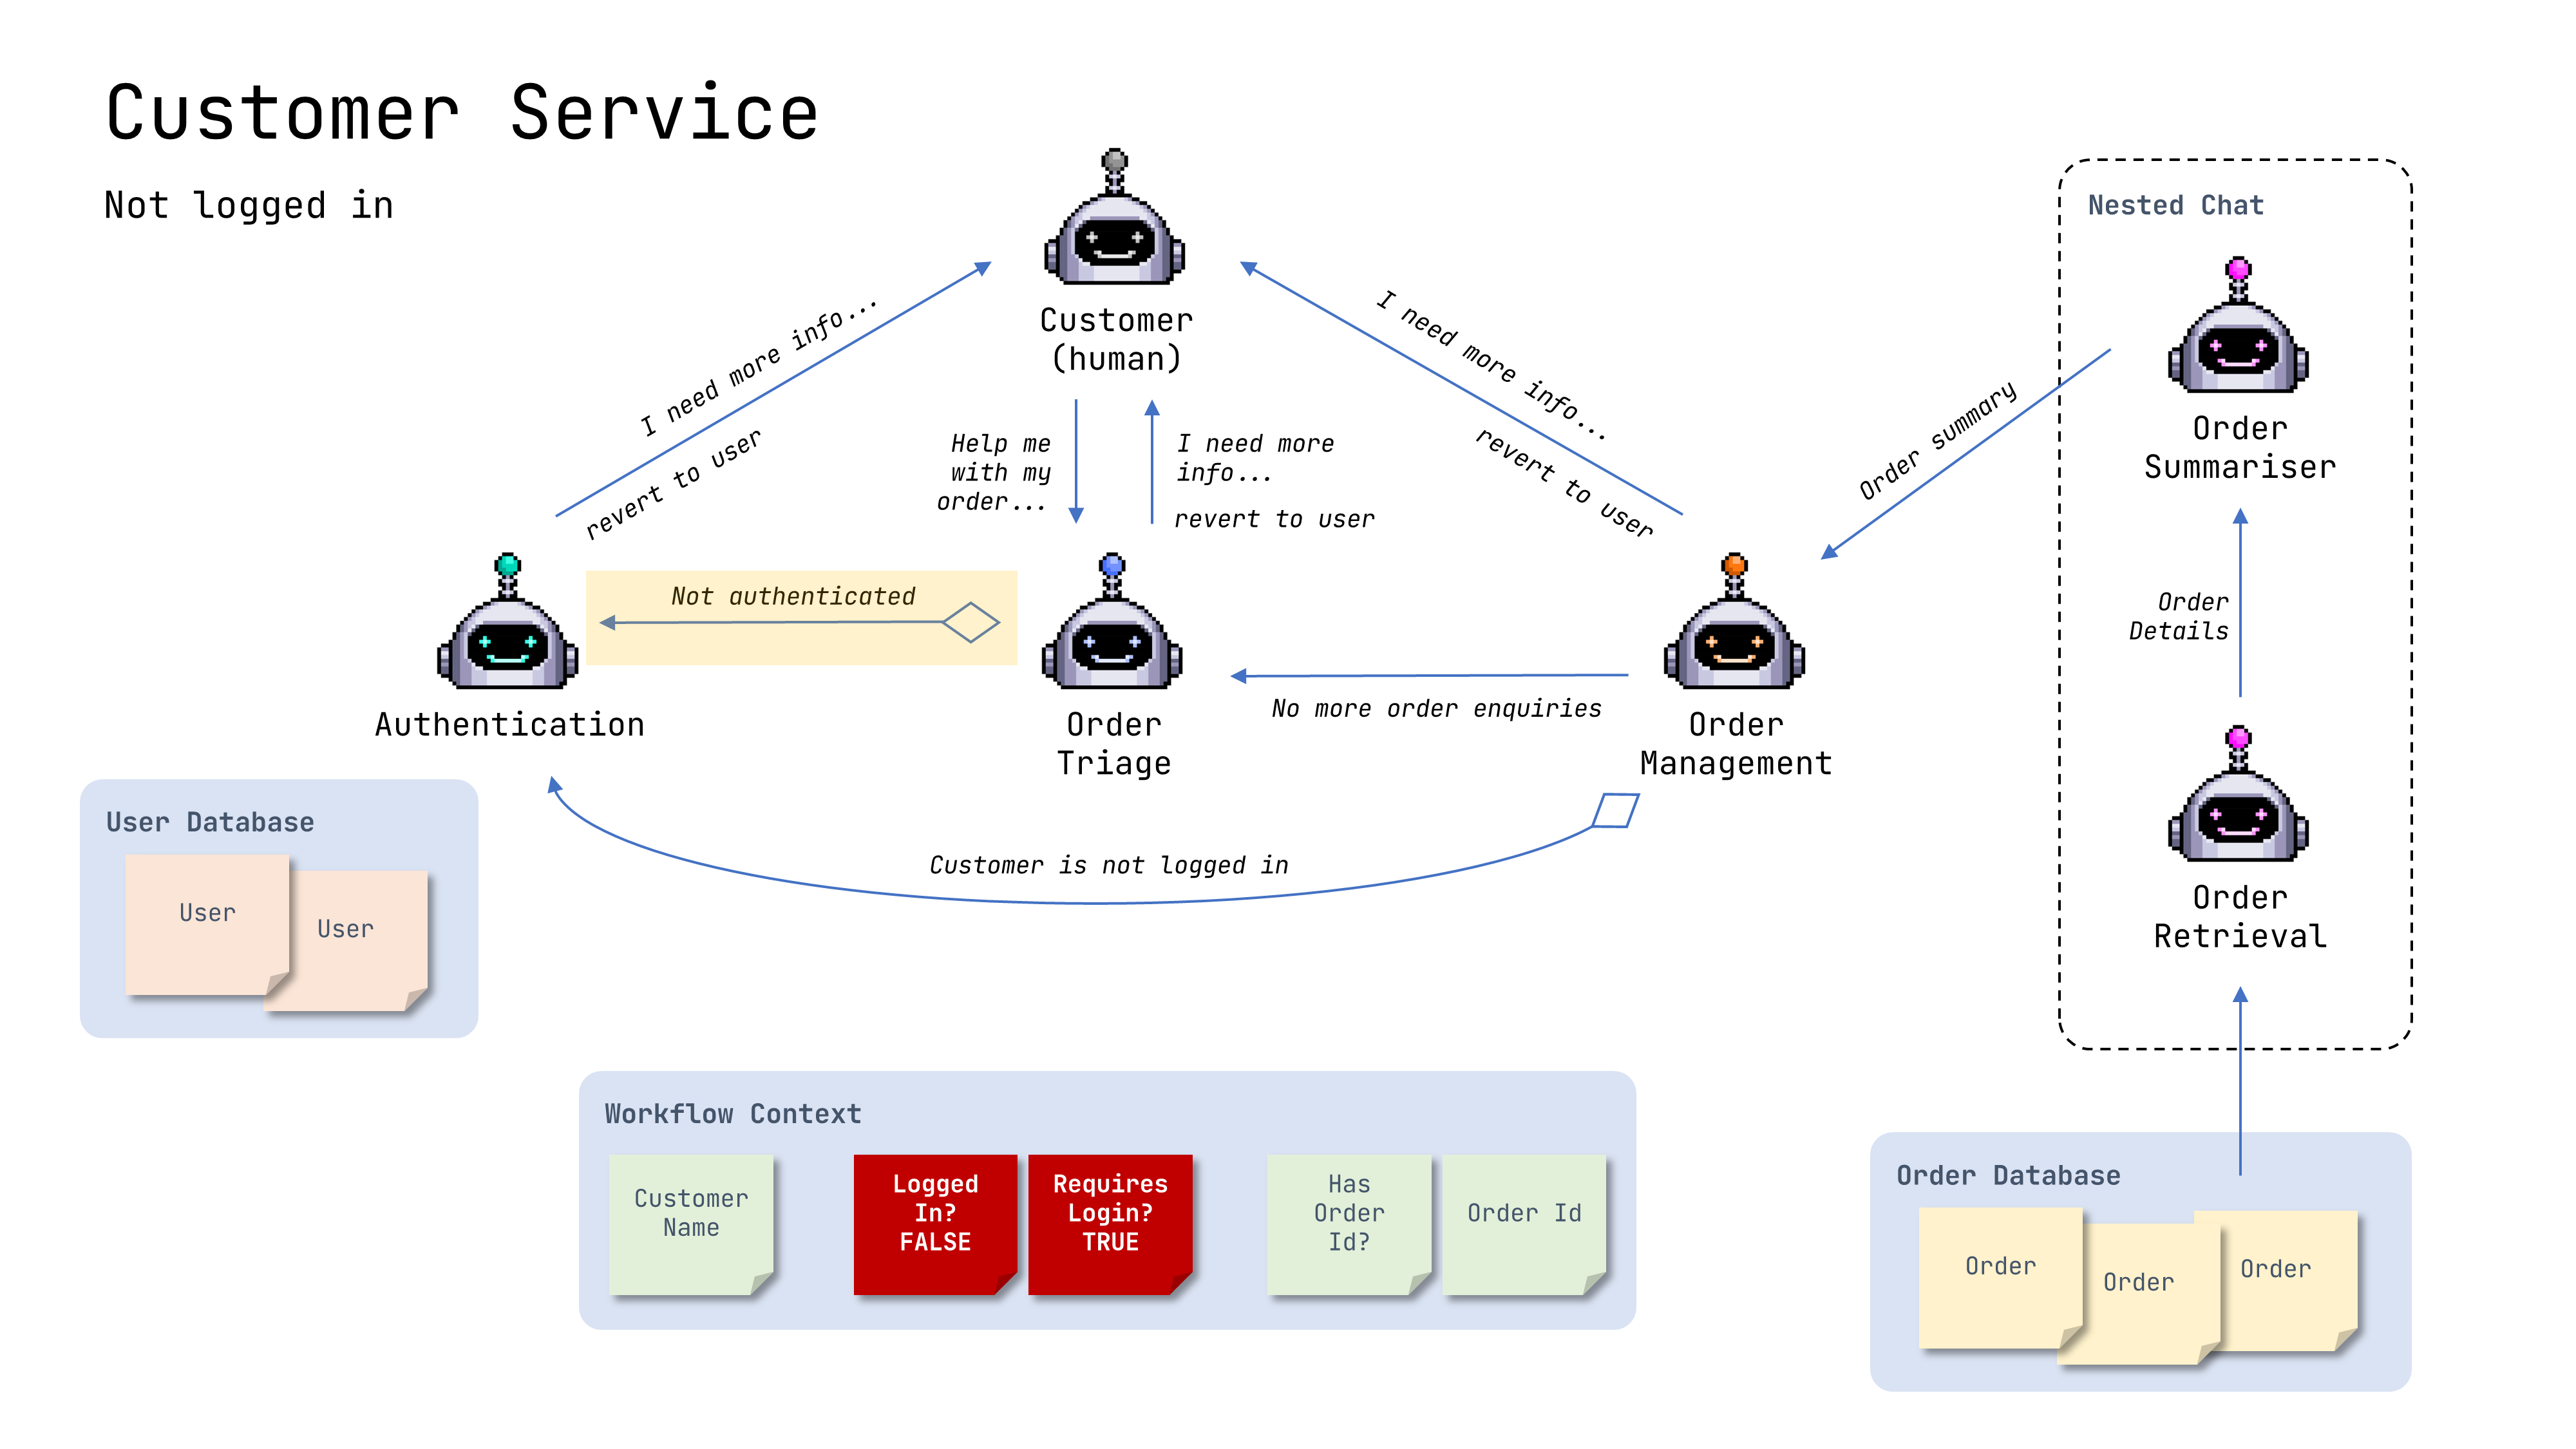

In [17]:
# At the beginning, we weren’t logged in and there was only one path.

Image(filename='swarm-enhanced-02.png')

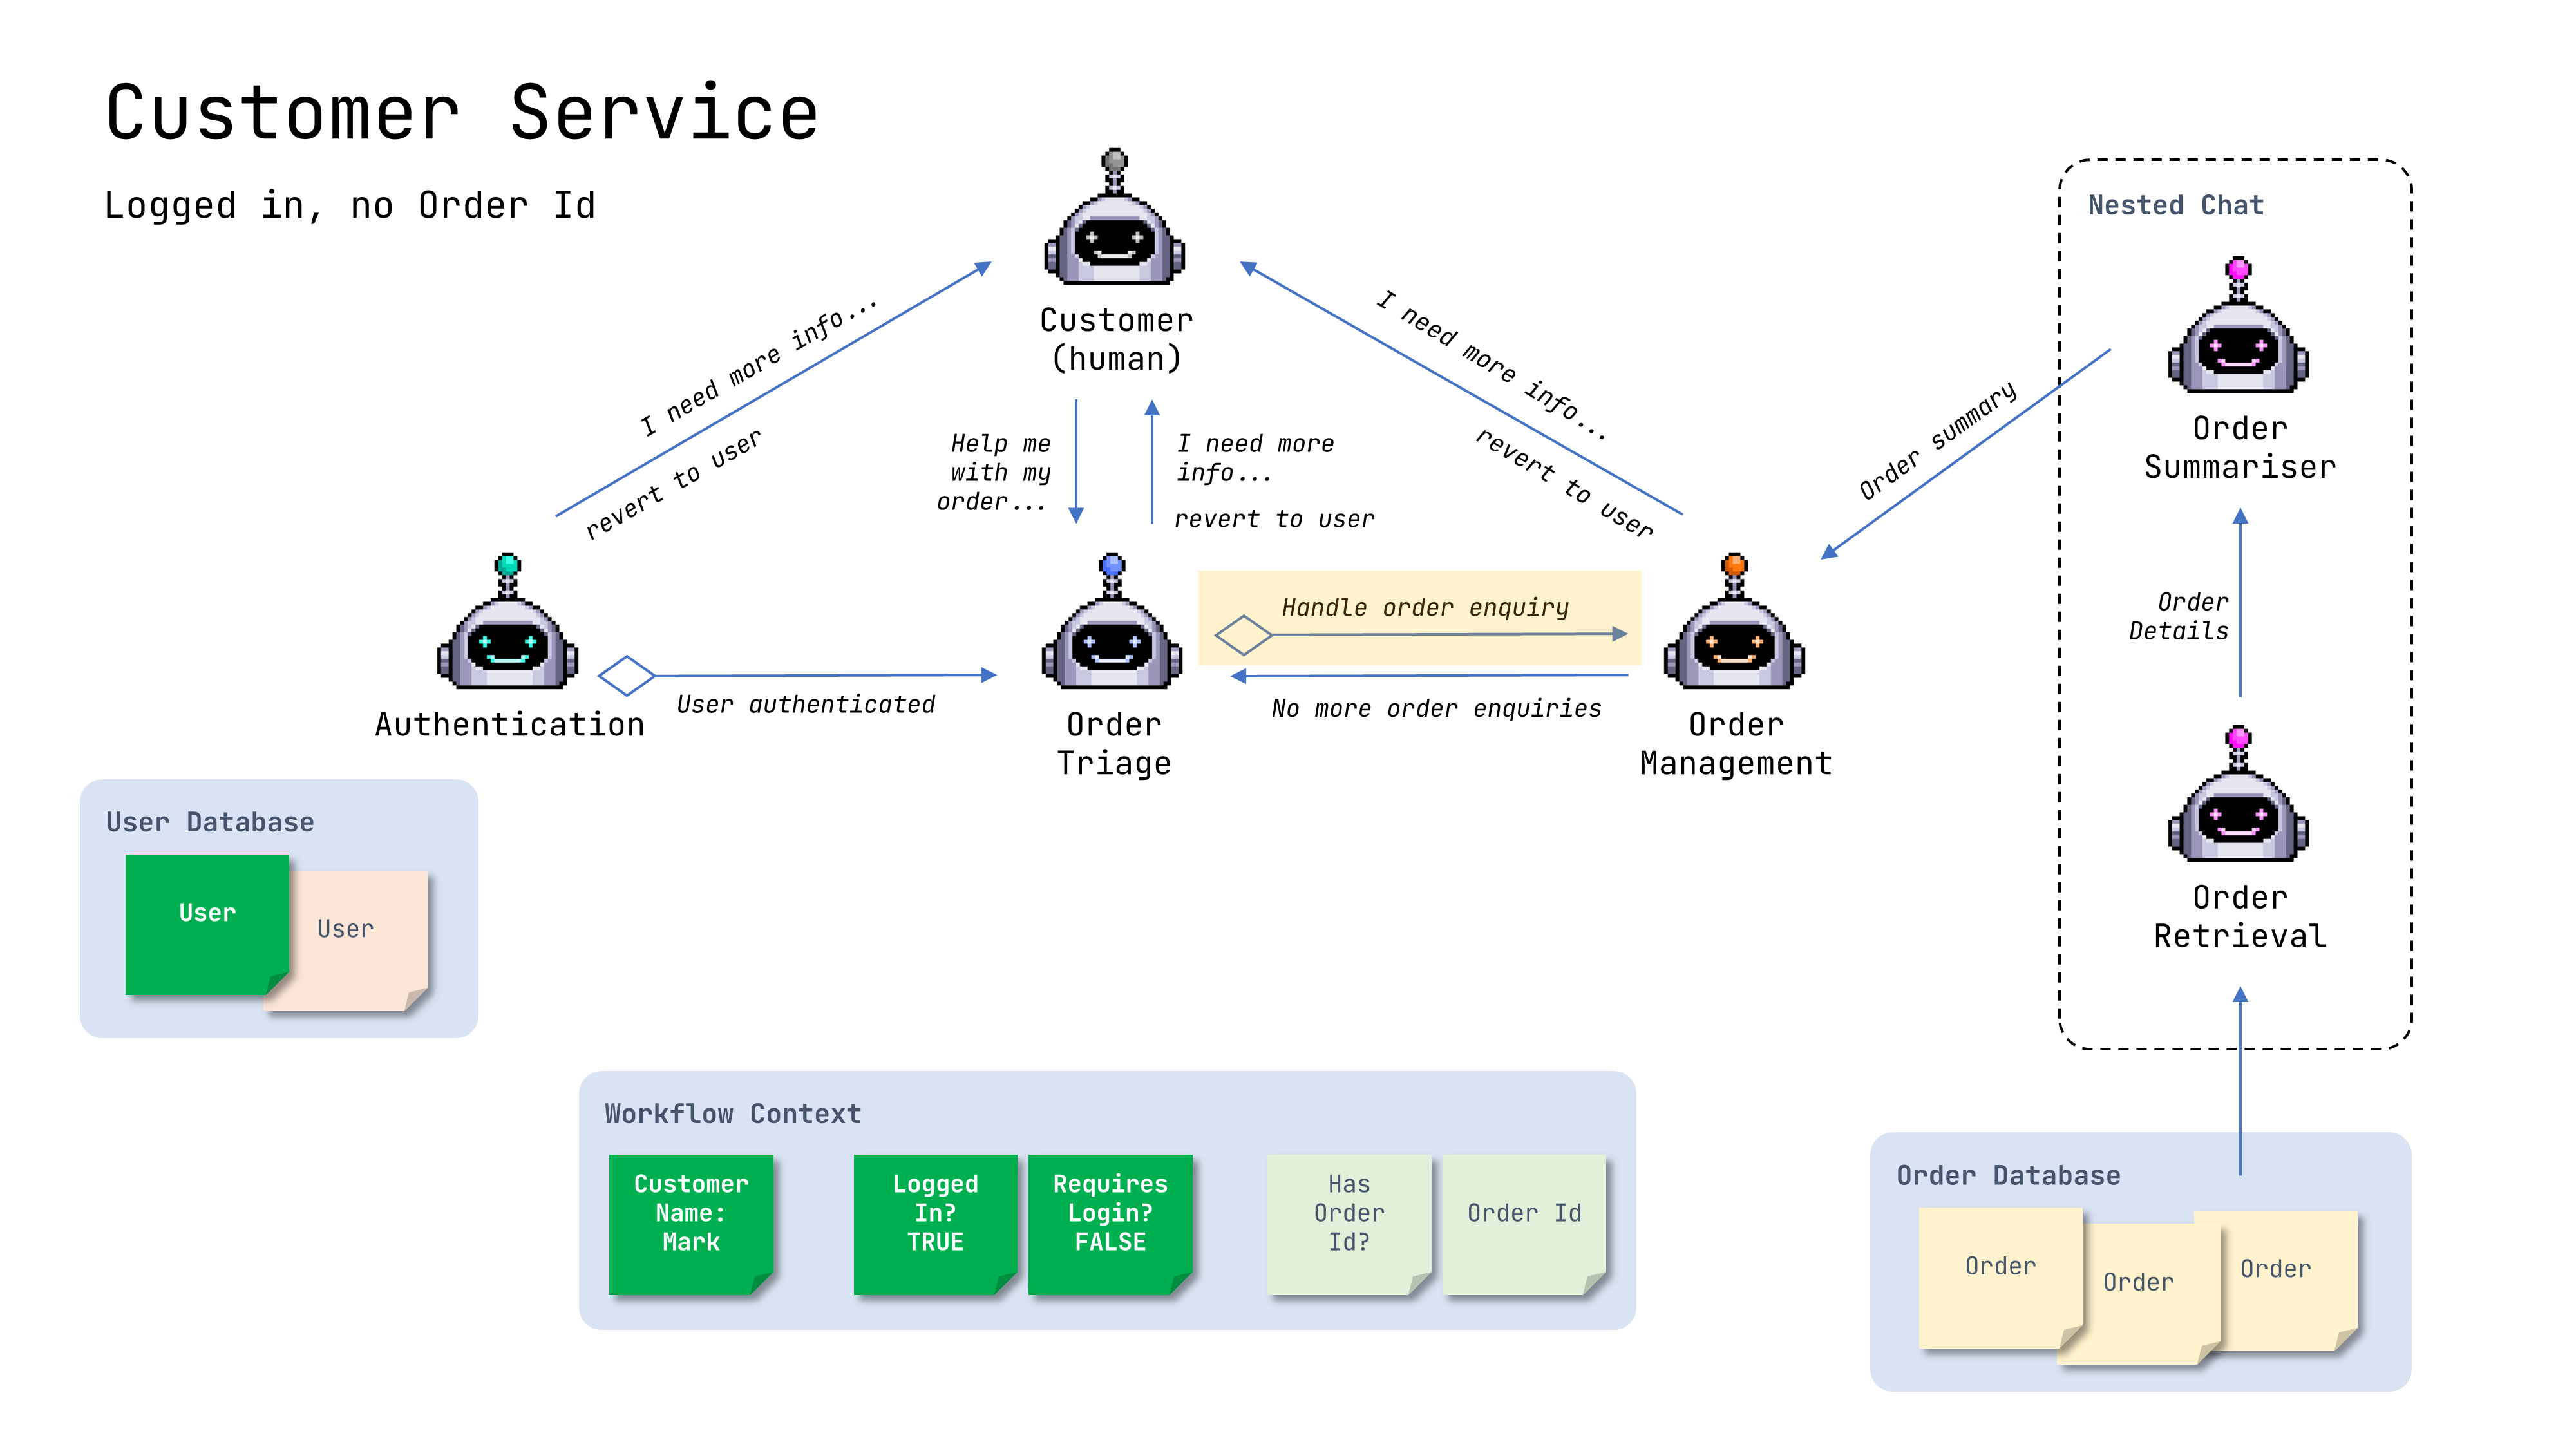

In [18]:
# After we logged in, we needed to get the order id.

Image(filename='swarm-enhanced-03.png')

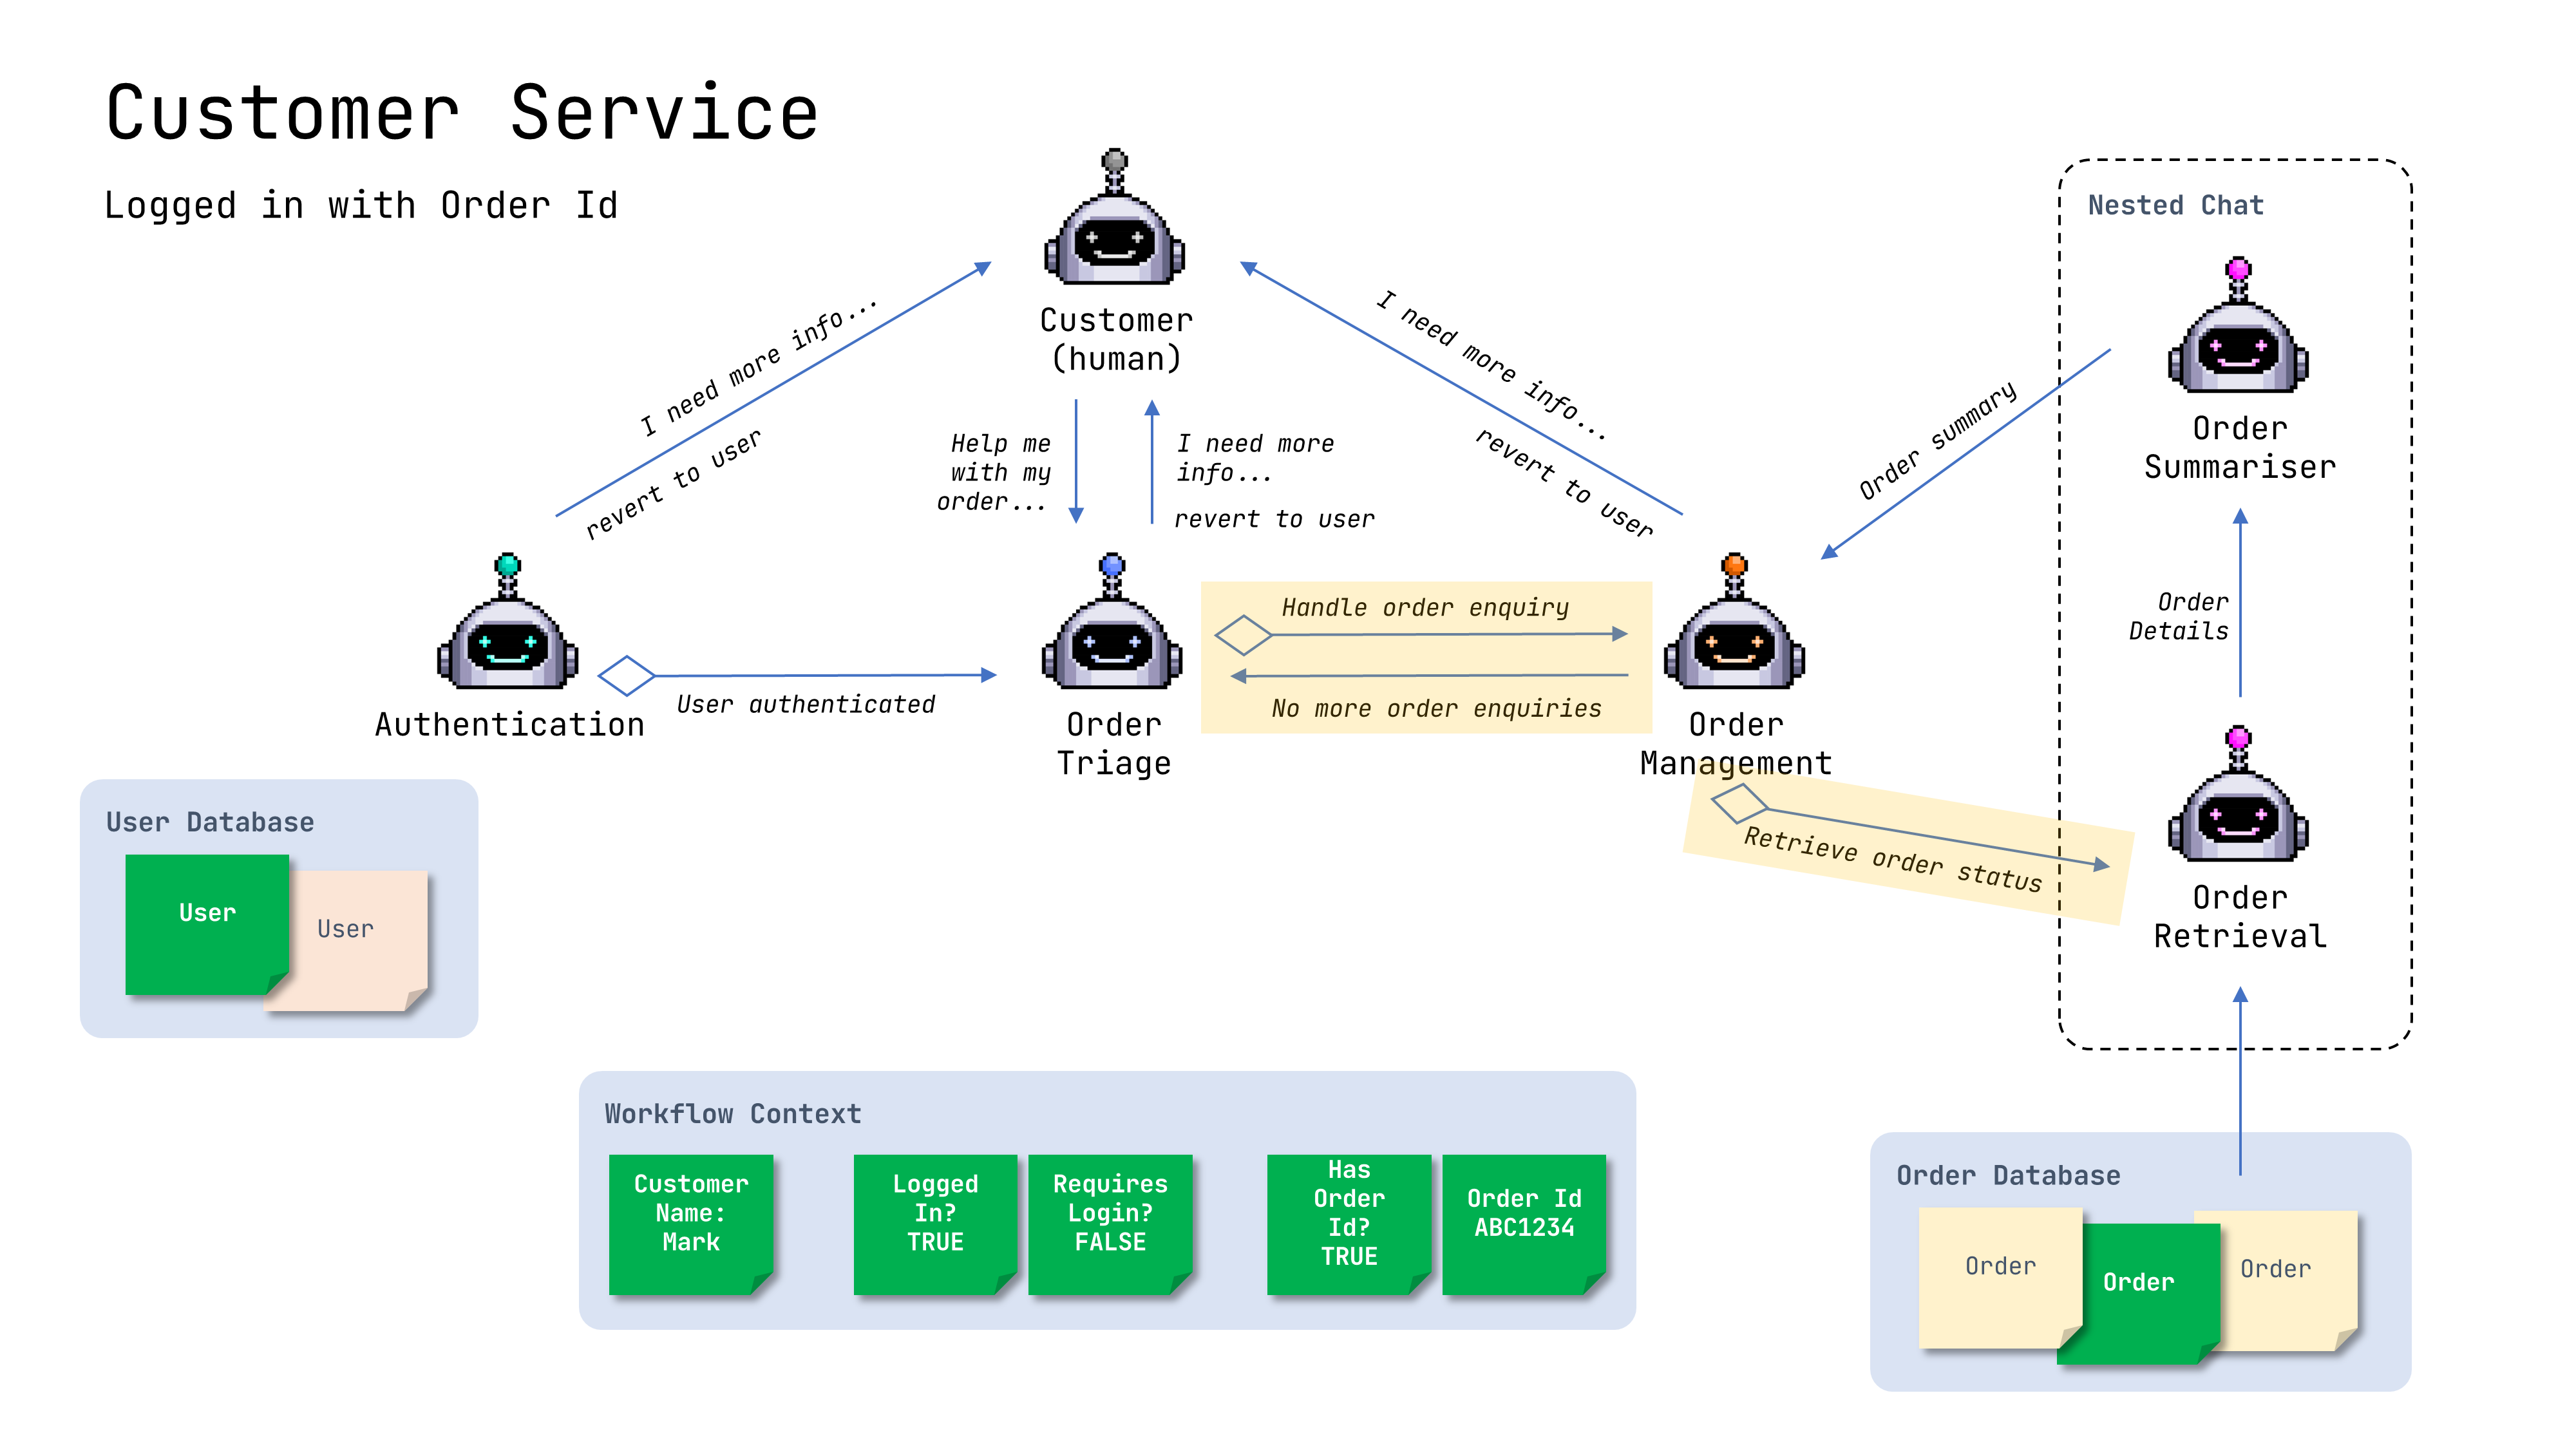

In [19]:
# With the order id, we can handle order enquiries and retrieve order details.

Image(filename='swarm-enhanced-04.png')

### More Swarm examples
- [Introduction to Swarm notebook](https://docs.ag2.ai/docs/use-cases/notebooks/notebooks/agentchat_swarm)
- [Swarm with GraphRAG notebook](https://docs.ag2.ai/docs/use-cases/notebooks/notebooks/agentchat_swarm_graphrag_trip_planner)